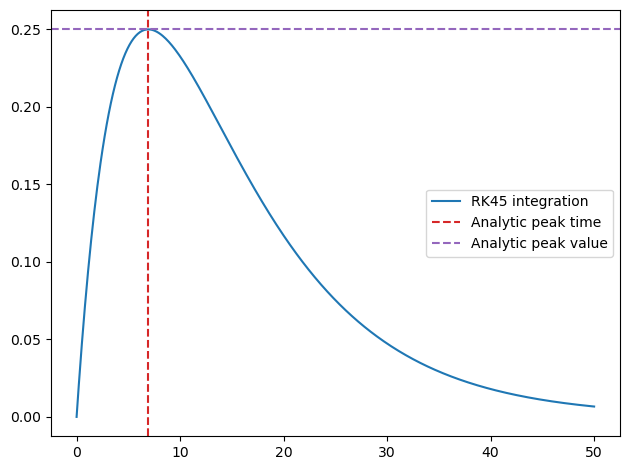

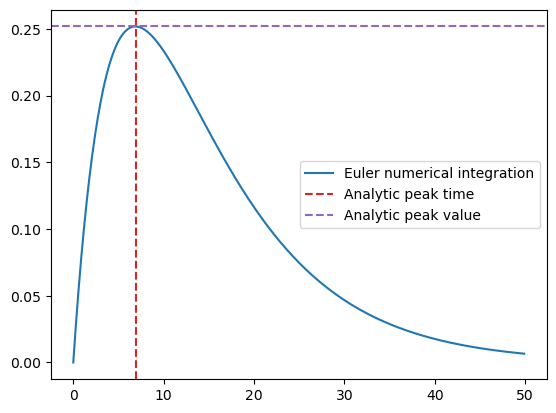

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Example of byexponential synapses - which describe the dynamics of synaptic conductance. Uses two exponential
# terms to describe the time course of synaptic conductance changes following presynaptic action potential/spike.

# a - scaling factor / amplitude of the synaptic conductance
# tau - time constant associated with the decay of the synaptic conductance.
# tau_x - time constant associated with the recovery of the synaptic resources of decay var x.

# Scipy's numerical ODE solver + analytical solution which derivation is not presented
def plot_biexponential_psp(a, tau, taux):
    # differential equation in right form for scipy
    def f(t, z, a, tau, taux):
        v, x = z
        return [(a*x-v)/tau, -x/taux]
    plt.figure()
    # solution using scipy diffeq solver
    sol = solve_ivp(f, [0, 50], [0, 1], args=(a, tau, taux), max_step=0.1)
    plt.plot(sol.t, sol.y[0], label='RK45 integration')
    # analytic solution
    tmax = tau*taux/(tau-taux)*np.log(tau/taux)
    plt.axvline(tmax, ls='--', c='C3', label='Analytic peak time')
    plt.axhline(((taux/tau)**(tau/(tau-taux))), ls='--', c='C4', label='Analytic peak value')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

plot_biexponential_psp(1, 10, 5)

# Euler integration using for loops
def plot_biexponential_euler(a, tau, taux):
  def f(z, a, tau, taux):
    v, x = z
    return np.array([(a*x-v)/tau, -x/taux], dtype=float)

  plt.figure()
  T = 50 # total time of simulation
  dt = 0.1
  time_steps = np.arange(0, T, dt)
  z = np.array([0, 1], dtype=float)
  results = np.zeros((len(time_steps), 2))
  maximum_val = float('-inf')
  maximum_t = 0
  for i, t in enumerate(time_steps):
    results[i] = z
    if z[0] > maximum_val:
      maximum_val = z[0]
      maximum_t = t
    derivatives = f(z, a, tau, taux)
    z += dt * derivatives

  plt.plot(time_steps, results[:, 0], label='Euler numerical integration')
  plt.axvline(maximum_t, ls='--', c='C3', label='Analytic peak time')
  plt.axhline(maximum_val, ls='--', c='C4', label='Analytic peak value')

  plt.legend(loc='best')
  plt.show()

plot_biexponential_euler(1, 10, 5)

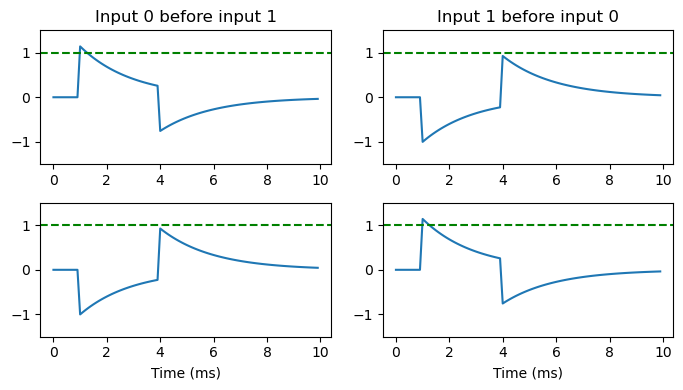

In [7]:
# Implement Order Sensitive Network
# Each output neuron receives an excitatory input from the input spike train with the same index,
# and an inhibitory input from the input spike train with the other index.

# vt is the spike threshold (we set it to a large value in the plotting code below to see what's going on)
def simulate_order_network(spikes, tau, taux, we, wi, vt=1, dt=0.1):
    def f(z, a, tau, taux):
      v, x = z
      return np.array([(a*x-v)/tau, -x/taux], dtype=float)

    num_neurons = 2
    num_time_steps = spikes.shape[1]
    # state variables
    v = np.zeros(num_neurons)
    x = np.zeros(num_neurons)
    # record activity
    v_rec = np.zeros((num_neurons, num_time_steps))
    spike_count = np.zeros(num_neurons)

    v = np.zeros(num_neurons)

    z = np.array([[0, 0], [0, 0]], dtype=float)

    # create the simulation with inhibitory and excitatory synapses
    for i in range(num_time_steps):
      for neuron in range(num_neurons):
        if spikes[neuron][i] == 1:
          z[neuron][0] += we

        derivatives = f(z[neuron], 1, tau, taux)
        z[neuron] += dt * derivatives

        # inhibition
        other_neuron = 1 - neuron
        if spikes[other_neuron][i] == 1:
          z[neuron][0] -= wi

        v_rec[neuron][i] = z[neuron][0]
        if z[neuron][0] >= vt:
          spike_count[neuron] += 1


    return v_rec, spike_count

def plotit(order):
    dt = 0.1
    # Input data
    spikes = np.zeros((2, 100))
    spikes[order, 10] = spikes[1-order, 40] = 1
    # Model with threshold set to 10 so we can see traces without spikes
    v, spike_count = simulate_order_network(spikes, tau=2, taux=3, we=1.2, wi=1, vt=10, dt=dt)
    # Plot
    T = np.arange(v.shape[1])*dt
    for i in range(2):
        plt.subplot(2, 2, 2*i+1+order)
        plt.plot(T, v[i, :])
        plt.axhline(1, ls='--', c='g')
        plt.ylim(-1.5, 1.5)
        if i:
            plt.xlabel('Time (ms)')
        else:
            plt.title(f'Input {order} before input {1-order}')

plt.figure(figsize=(7, 4))
plotit(0)
plotit(1)
plt.tight_layout();